In [1]:
import os
import torch
import numpy as np
from tqdm.notebook import tqdm
import imageio
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence as pack_sequence, pad_packed_sequence as unpack_sequence
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import torchvision.models as models
# io utils
from pytorch3d.io import load_obj

# datastructures
from pytorch3d.structures import Meshes

# 3D transformations functions
from pytorch3d.transforms import Rotate, Translate

# rendering components
from pytorch3d.renderer import (
    FoVPerspectiveCameras, look_at_view_transform, look_at_rotation, 
    RasterizationSettings, MeshRenderer, MeshRasterizer, BlendParams,
    SoftSilhouetteShader, HardPhongShader, SoftPhongShader, AmbientLights, PointLights, TexturesUV, TexturesVertex,
)

import vtk
import sys
sys.path.insert(0,'..')
import fly_by_features as fbf
from vtk.util.numpy_support import vtk_to_numpy
from vtk.util.numpy_support import numpy_to_vtk
import pandas as pd
from sklearn.model_selection import train_test_split
from skimage import img_as_ubyte

import monai
from monai.data import ITKReader, PILReader
from monai.transforms import (
    ToTensor, LoadImage, Lambda, AddChannel, RepeatChannel, ScaleIntensityRange, RandSpatialCrop,
    Resized, Compose
)
from monai.config import print_config
from monai.metrics import DiceMetric
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots



In [2]:
# Set the cuda device 
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")
    
 

In [3]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x

class TimeDistributed(nn.Module):
    def __init__(self, module):
        super(TimeDistributed, self).__init__()
        self.module = module
 
    def forward(self, input_seq):
        assert len(input_seq.size()) > 2
 
        # reshape input data --> (samples * timesteps, input_size)
        # squash timesteps

        size = input_seq.size()

        batch_size = size[0]
        time_steps = size[1]

        size_reshape = [batch_size*time_steps] + list(size[2:])
        reshaped_input = input_seq.contiguous().view(size_reshape)
 
        output = self.module(reshaped_input)
        
        output_size = output.size()
        output_size = [batch_size, time_steps] + list(output_size[1:])
        output = output.contiguous().view(output_size)

        return output

# class MoveNet(nn.Module):
#     def __init__(self):
#         super(MoveNet, self).__init__()

#         resnet = models.resnet34(pretrained=True)
#         resnet.fc = Identity()
#         resnet.conv1 = nn.Conv2d(4, 64, kernel_size=7, stride=2, padding=3, bias=False)
#         self.resnet = resnet
        
#         self.MovePrediction = nn.Linear(512, 6)
        
#     def forward(self, x):
 
#         x = self.resnet(x)
#         x = self.MovePrediction(x)

#         return x
    
class MoveNet(nn.Module):
    def __init__(self, renderer):
        super().__init__()

        self.renderer = renderer
        
        resnet = models.resnet34(pretrained=True)
        resnet.fc = Identity()
        resnet.conv1 = nn.Conv2d(4, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.resnet = resnet
        
        self.MovePrediction = nn.Linear(512, 6)


    def forward(self, x, meshes, camera_position, focal_point):
        
        x = self.resnet(x)
        x = self.MovePrediction(x)
        
        camera_position += x[:,0:3]
        focal_point += x[:,3:6]
        
        R = look_at_rotation(camera_position, at=focal_point).to(camera_position.device)  # (1, 3, 3)
        T = -torch.bmm(R.transpose(1, 2), camera_position[:,:,None])[:, :, 0]   # (1, 3)
        
        image = self.renderer(meshes_world=meshes.clone(), R=R, T=T)

        pix_to_face, zbuf, bary_coords, dists = self.renderer.rasterizer(meshes)

        img_regionid_pid = torch.take(faces_pid0, pix_to_face.reshape(-1))
        y_p = torch.take(region_id, img_regionid_pid.to(torch.int64))*(pix_to_face.reshape(-1)>= 0).to(torch.float32)

        x = torch.cat([image[..., 0:3], zbuf], dim=-1).permute(0, 3, 1, 2)
        
        return x.detach(), y_p.detach(), pix_to_face, camera_position, focal_point
    
class PaintNet(nn.Module):
    def __init__(self):
        super(PaintNet, self).__init__()

        self.unet = monai.networks.nets.UNETR(in_channels=4, out_channels=4, img_size=224, feature_size=32, spatial_dims=2)
        
 
    def forward(self, x):
 
        x = self.unet(x)

        return x


def paint_surface(surf, pids, value, neighbors=2):    
    
    all_pids = pids
    for l in range(neighbors):
        pids = fbf.GetAllNeighbors(surf, pids)
        all_pids = np.concatenate((all_pids, pids))

    all_pids = np.unique(all_pids)

    for pid in all_pids:
        surf.GetPointData().GetScalars().SetTuple1(pid, value)

    surf.GetPointData().GetScalars().Modified()

def random_choice(x):
    idx = torch.randint(x.size(0), (50,))
    x = x[idx]
    return x

def GetColorTable(surf, property_name, range_scalars = None):

    if range_scalars == None:
        range_scalars = surf.GetPointData().GetScalars(property_name).GetRange()

    hueLut = vtk.vtkLookupTable()
    hueLut.SetTableRange(0, range_scalars[1])
    hueLut.SetHueRange(0.0, 0.9)
    hueLut.SetSaturationRange(1.0, 1.0)
    hueLut.SetValueRange(1.0, 1.0)
    hueLut.Build()
    
    colors = []
    for i in range(int(range_scalars[1] + 1)):
        color = [0,0,0]
        hueLut.GetColor(i, color)
        colors.append(color)
    
    return np.array(colors)


In [4]:
# idx = 0

# surf = fbf.ReadSurf(df.iloc[idx]["surf"])
# surf = fbf.GetUnitSurf(surf)
# surf, _a, _v = fbf.RandomRotation(surf)

# surf = fbf.ComputeNormals(surf)

# verts = ToTensor(dtype=torch.float32, device=device)(vtk_to_numpy(surf.GetPoints().GetData()))
# faces = ToTensor(dtype=torch.int32, device=device)(vtk_to_numpy(surf.GetPolys().GetData()).reshape(-1, 4)[:,1:])
# region_id = ToTensor(dtype=torch.int64, device=device)(vtk_to_numpy(surf.GetPointData().GetScalars("RegionId")))
# region_id = torch.clamp(region_id, min=0)
# faces_pid0 = faces[:,0:1]
# color_normals = ToTensor(dtype=torch.float32, device=device)(vtk_to_numpy(fbf.GetColorArray(surf, "Normals"))/255.0)
# color_points = ToTensor(dtype=torch.float32, device=device)(GetColorTable(surf, "RegionId"))
# color_points = torch.index_select(color_points, dim=0, index=region_id)

In [5]:
# textures = TexturesVertex(verts_features=[color_points])
# mesh = Meshes(
#     verts=[verts],   
#     faces=[faces], 
#     textures=textures
# )

In [6]:
# Initialize a perspective camera.
cameras = FoVPerspectiveCameras(device=device)

# To blend the 100 faces we set a few parameters which control the opacity and the sharpness of 
# edges. Refer to blending.py for more details. 
blend_params = BlendParams(sigma=1e-4, gamma=1e-4)

# Define the settings for rasterization and shading. Here we set the output image to be of size
# 256x256. To form the blended image we use 100 faces for each pixel. We also set bin_size and max_faces_per_bin to None which ensure that 
# the faster coarse-to-fine rasterization method is used. Refer to rasterize_meshes.py for 
# explanations of these parameters. Refer to docs/notes/renderer.md for an explanation of 
# the difference between naive and coarse-to-fine rasterization. 
raster_settings = RasterizationSettings(
    image_size=224, 
    blur_radius=np.log(1. / 1e-4 - 1.) * blend_params.sigma, 
    faces_per_pixel=100, 
)

# Create a silhouette mesh renderer by composing a rasterizer and a shader. 
silhouette_renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=SoftSilhouetteShader(blend_params=blend_params)
)


# We will also create a Phong renderer. This is simpler and only needs to render one face per pixel.
raster_settings = RasterizationSettings(
    image_size=224, 
    blur_radius=0, 
    faces_per_pixel=1, 
)
# We can add a point light in front of the object. 

# lights = AmbientLights(device=device)
lights = PointLights(device=device)
rasterizer = MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    )
phong_renderer = MeshRenderer(
    rasterizer=rasterizer,
    shader=HardPhongShader(device=device, cameras=cameras)
)

In [7]:
# # Select the viewpoint using spherical angles  
# distance = 2   # distance from camera to the object
# elevation = 90.0   # angle of elevation in degrees
# azimuth = 0.0  # No rotation so the camera is positioned on the +Z axis. 

# # Get the position of the camera based on the spherical angles
# R, T = look_at_view_transform(distance, elevation, azimuth, device=device)

# # Render the teapot providing the values of R and T. 
# silhouette = silhouette_renderer(meshes_world=mesh, R=R, T=T)
# image_ref = phong_renderer(meshes_world=mesh, R=R, T=T)

# silhouette = silhouette.cpu().numpy()
# image_ref = image_ref.cpu().numpy()

# plt.figure(figsize=(20, 20))
# plt.subplot(1, 2, 1)
# plt.imshow(silhouette.squeeze()[..., 3])  # only plot the alpha channel of the RGBA image
# plt.grid(False)
# plt.subplot(1, 2, 2)
# plt.imshow(image_ref.squeeze())
# plt.grid(False)

In [8]:
# pix_to_face, zbuf, bary_coords, dists = rasterizer(mesh)

# plt.figure(figsize=(10, 10))
# plt.imshow(zbuf.squeeze().cpu().numpy())


# img_regionid_pid = torch.take(faces_pid0, pix_to_face.reshape(-1))
# img_regionid = torch.take(region_id, img_regionid_pid.to(torch.int64))*(pix_to_face.reshape(-1)>= 0).to(torch.float32)

# plt.figure(figsize=(10, 10))
# plt.imshow(img_regionid.reshape(224, 224, 1).cpu().numpy(), cmap='gray', vmin=0, vmax=3)

In [9]:
# Initialize a perspective camera.
cameras = FoVPerspectiveCameras(device=device)


# We will also create a Phong renderer. This is simpler and only needs to render one face per pixel.
raster_settings = RasterizationSettings(
    image_size=224, 
    blur_radius=0, 
    faces_per_pixel=1, 
)
# We can add a point light in front of the object. 

# lights = AmbientLights(device=device)
lights = PointLights(device=device)
rasterizer = MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    )
phong_renderer = MeshRenderer(
    rasterizer=rasterizer,
    shader=HardPhongShader(device=device, cameras=cameras)
)

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class FlyByDataset(Dataset):
    def __init__(self, df):
        self.df = df

    def set_env_params(self, params):
        self.params = params

    def __len__(self):
        return len(self.df.index)

    def __getitem__(self, idx):
        
        surf = fbf.ReadSurf(df.iloc[idx]["surf"])
        surf = fbf.GetUnitSurf(surf)
        surf, _a, _v = fbf.RandomRotation(surf)

        surf = fbf.ComputeNormals(surf)

        color_normals = ToTensor(dtype=torch.float32, device=device)(vtk_to_numpy(fbf.GetColorArray(surf, "Normals"))/255.0)
        verts = ToTensor(dtype=torch.float32, device=device)(vtk_to_numpy(surf.GetPoints().GetData()))
        faces = ToTensor(dtype=torch.int64, device=device)(vtk_to_numpy(surf.GetPolys().GetData()).reshape(-1, 4)[:,1:])
        region_id = ToTensor(dtype=torch.int64, device=device)(vtk_to_numpy(surf.GetPointData().GetScalars("UniversalID")))
        region_id = torch.clamp(region_id, min=0)
        faces_pid0 = faces[:,0:1]
        region_id_faces = torch.take(region_id, faces_pid0)
        #print("shape region_id_faces: ", region_id_faces.shape)
        
        return verts, faces, region_id, region_id_faces, faces_pid0, color_normals
        
def pad_verts_faces(batch):
    verts = [v for v, f, rid, ridf, fpid0, cn in batch]
    faces = [f for v, f, rid, ridf, fpid0, cn in batch]
    region_ids = [rid for v, f, rid, ridf, fpid0, cn in batch]
    region_ids_faces = [ridf for v, f, rid, ridf, fpid0, cn in batch]
    faces_pid0s = [fpid0 for v, f, rid, ridf, fpid0, cn in batch]
    color_normals = [cn for v, f, rid, ridf, fpid0, cn in batch]
    
    pad_seq_verts = pad_sequence(verts, batch_first=True, padding_value=0.0)
    pad_seq_faces = pad_sequence(faces, batch_first=True, padding_value=-1)
    pad_seq_rid = pad_sequence(region_ids, batch_first=True, padding_value=0)
    pad_seq_faces_pid0s = pad_sequence(faces_pid0s, batch_first=True, padding_value=-1)
    pad_seq_cn = pad_sequence(color_normals, batch_first=True, padding_value=0.)
    l = [f.shape[0] for f in faces]
    return pad_seq_verts, pad_seq_faces, pad_seq_rid, torch.cat(region_ids_faces), pad_seq_faces_pid0s, pad_seq_cn, l
        
df = pd.read_csv("/ASD/juan_flyby/DCBIA/UniversalId_train.csv")
#df = pd.read_csv("/NIRAL/work/leclercq/data/training_UID.csv")
df_train, df_val = train_test_split(df, test_size=0.1)              
train_data = FlyByDataset(df_train)
val_data = FlyByDataset(df_val)

train_dataloader = DataLoader(train_data, batch_size=4, shuffle=True, collate_fn=pad_verts_faces)
from icecream import ic

In [10]:

for batch, (V, F, Y, YF, F0, CN, FL) in enumerate(train_dataloader):
    
    print("batch no: ", batch)
    """
    print("shape V : ",V.shape)
    print("shape F : ",F.shape)
    print("shape Y : ",Y.shape)
    print("shape YF : ",YF.shape)
    
    print("shape F0 : ",F0.shape)
    print("shape F0[0] : ",F0[0].shape)
    """
    ic(CN.shape)
    
    textures = TexturesVertex(verts_features=CN)
    meshes = Meshes(
        verts=V,   
        faces=F, 
        textures=textures
    )

    ic(V.shape)
    ic(F.shape)
    ic(CN.shape)
    ic(YF.shape)
    # camera_positions = ToTensor(dtype=torch.float32, device=device)([[0, 0, 4]]).repeat(8, 1)
    camera_position = ToTensor(dtype=torch.float32, device=device)([[0, 0, 1.25]])
    R = look_at_rotation(camera_position, device=device)  # (1, 3, 3)
    T = -torch.bmm(R.transpose(1, 2), camera_position[:,:,None])[:, :, 0]   # (1, 3)
    
    images = phong_renderer(meshes_world=meshes.clone(), R=R, T=T)    
    pix_to_face, zbuf, bary_coords, dists = phong_renderer.rasterizer(meshes.clone())
    
    print("shape images : ",images.shape)
    print("shape pix_to_face : ",pix_to_face.shape)

    y_p = torch.take(YF, pix_to_face)*(pix_to_face >= 0)    
    break

batch no:  0


ic| CN.shape: torch.Size([4, 145020, 3])
ic| V.shape: torch.Size([4, 145020, 3])
ic| F.shape: torch.Size([4, 287418, 3])
ic| CN.shape: torch.Size([4, 145020, 3])
ic| YF.shape: torch.Size([887678, 1])


shape images :  torch.Size([4, 224, 224, 4])
shape pix_to_face :  torch.Size([4, 224, 224, 1])


In [11]:
    #img_regionid_pid = [torch.take(F0[idx], ptf) for idx, ptf in enumerate(pix_to_face)]
    # img_regionid_pid = torch.stack([torch.take(F0[idx], ptf) for idx, ptf in enumerate(pix_to_face)])
    # print('shape img_regionid_pid: ', img_regionid_pid.shape)
    
    
    # print("len img_regionid_pid : ",len(img_regionid_pid))    
    # print("shape img_regionid_pid[0] : ",img_regionid_pid[0].shape)
    
    # img_regionid_pid = torch.take(F0, pix_to_face).to(torch.int64)
    # img_regionid_pid = torch.gather()

    
    # y_p =[]
    # for idx,irp in enumerate (img_regionid_pid):
        # irp = irp.long()
        # y_p.append(torch.take(Y[idx],irp))
    # y_p = torch.stack(y_p)
    # print('type irp: ',irp.type())
    
    # y_p = torch.stack([torch.take(Y[idx], irp) for idx, irp in enumerate(img_regionid_pid)])
    # y_p = y_p*(pix_to_face >= 0).to(torch.int64)
            

    # x = torch.cat([image[..., 0:3], zbuf], dim=-1).permute(0, 3, 1, 2)

In [12]:
print(images.type())
print("images shape: ",images.shape)
print("y_p shape: ", y_p.shape)
print(len(train_dataloader))
print(len(train_dataloader))
13*4+3
print(images.type())
print(y_p.type())
print(images[2][...,0:3].shape)

torch.cuda.FloatTensor
images shape:  torch.Size([4, 224, 224, 4])
y_p shape:  torch.Size([4, 224, 224, 1])
14
14
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.Size([224, 224, 3])


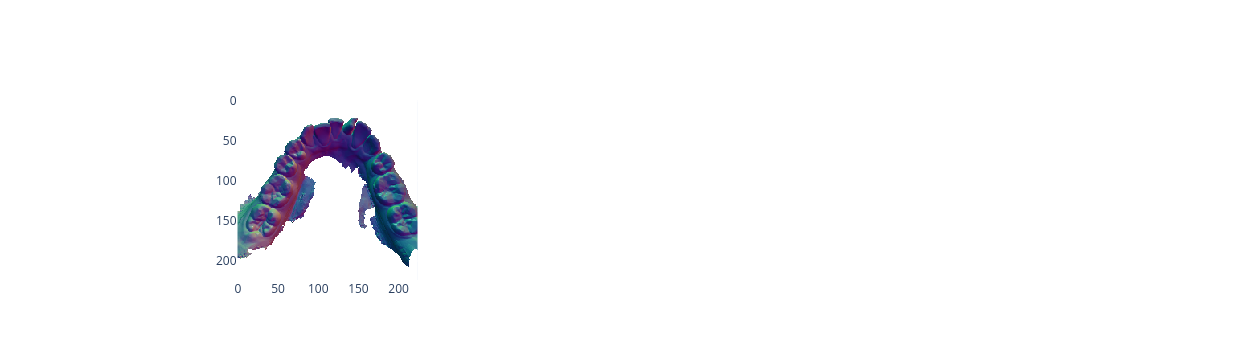

In [15]:
fig = go.Figure(make_subplots(rows=1, cols=2, column_widths=[0.5, 0.5], specs=[[{}, {}]]))
fig.add_trace(go.Image(z=(images[0][...,0:3]*255).cpu().numpy()), row=1, col=1)
"""
labelmap = np.flip((y_p[2][...,0]).cpu().numpy(), axis=0)
fig.add_trace(go.Heatmap(z=labelmap), row=1, col=2)
fig.update_layout(
    width = 1400, height = 700,
    autosize = False )
    """
fig